In [1]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

In [2]:
imagesDirectory = '../data/images/'

In [17]:
exampleIDs = """zbz-990107932800205508
zbz-990108038940205508
zbz-990051761550205508
zbz-990052035660205508
zbz-990052045460205508
zbz-990052047060205508
SFF_D_1512""".split("\n")

exampleImages = [join(imagesDirectory,d + '.jpg') for d in exampleIDs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(71, 66, 880, 1133)
(61, 61, 1002, 797)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0, 0, 1124, 903)
(100, 60, 927, 552)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(56, 56, 1015, 724)
(62, 65, 720, 595)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(886, 339, 153, 512)


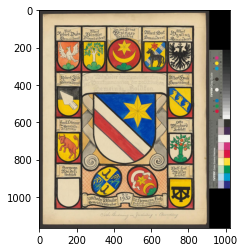

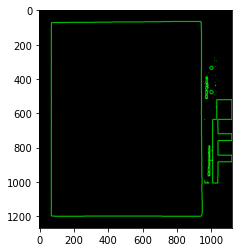

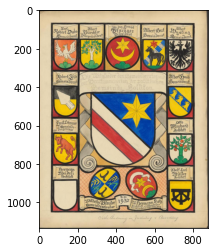

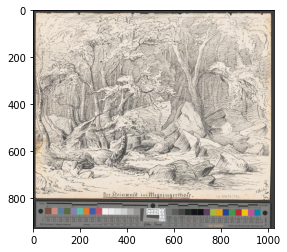

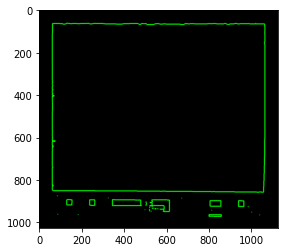

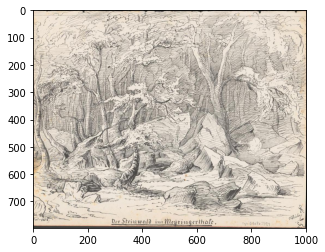

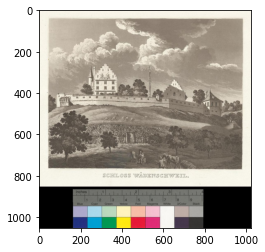

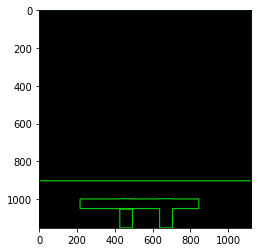

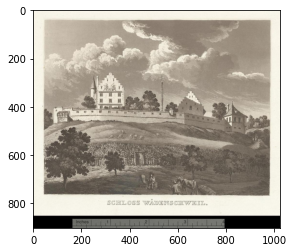

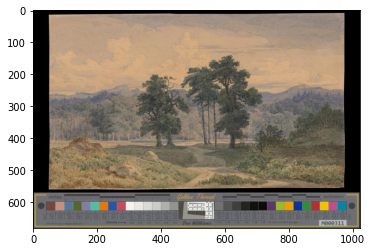

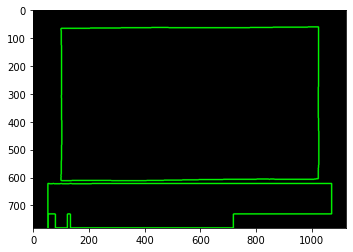

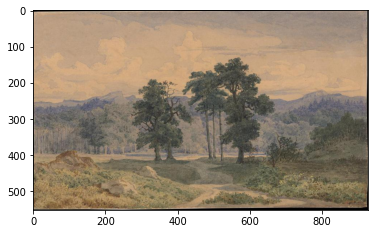

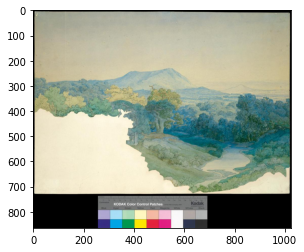

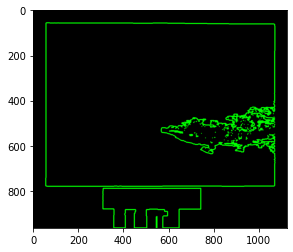

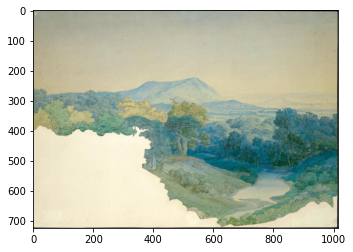

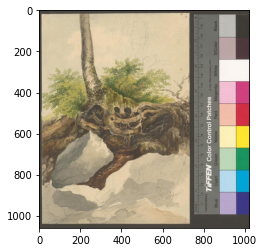

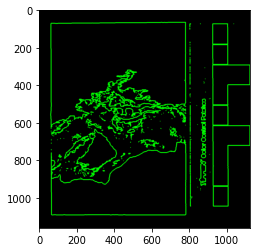

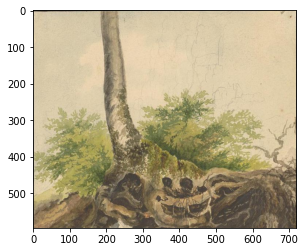

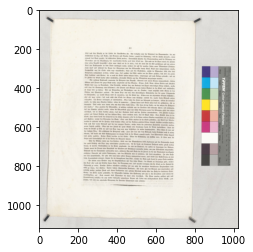

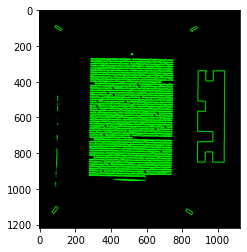

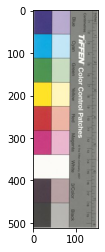

In [53]:
class BSOImageCropping:
    
    showImages = False
    extension = 50
    
    METHOD_TRHESH = 0
    METHOD_CANNY = 1

    SELECT_SQUAREST = 0
    SELECT_LARGEST = 1
    
    def __init__(self, showImages=False):
        self.showImages = showImages
        
    def applyMorphologyClose(self, image):
        padding = 15
        kernel = np.ones((2,10), np.uint8)
        if image[image.shape[0]-padding][padding] > 127:
            return cv2.morphologyEx(255-image.copy(), cv2.MORPH_CLOSE, kernel)
        else:
            return cv2.morphologyEx(image.copy(), cv2.MORPH_CLOSE, kernel)
    
    def blurImage(self, image, amount=5):
        return cv2.blur(image.copy(), (amount, amount))
    
    def cannyImage(self, image):
        return cv2.Canny(image.copy(), 10, 20)
    
    def displayImage(self, image):
        plt.figure()
        plt.imshow(image)
        
    def erodeImage(self, image, iterations=5):
        kernel = np.ones((5,5),np.uint8)
        return cv2.erode(image.copy(), kernel, iterations)
        
    def extendImage(self, image):
        return cv2.copyMakeBorder(image.copy(), self.extension, self.extension, self.extension, self.extension, cv2.BORDER_REPLICATE)
    
    def makeBW(self, image):
        return cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
        
    def thresholdImage(self, image):   
        padding = 5
        if image[image.shape[0]-padding][padding] > 127:
            thresholdMethod = cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
        else:
            thresholdMethod = cv2.THRESH_BINARY+cv2.THRESH_OTSU
        
        ret, thresh = cv2.threshold(image,0,255,thresholdMethod)   
        return thresh
    
    def cropImage(self, image, preprocessMethod=METHOD_TRHESH, selectMethod=SELECT_SQUAREST):        
        extendedImage = self.extendImage(image)
        grayImage = self.makeBW(extendedImage)
        morphImage = self.applyMorphologyClose(grayImage)
        #blurImage = self.blurImage(morphImage)
        
        if preprocessMethod == self.METHOD_CANNY:
            thresh = self.cannyImage(morphImage)
        else:
            thresh = self.thresholdImage(morphImage)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contourImage = np.zeros(extendedImage.shape)
        cv2.drawContours(contourImage, contours, -1, (0,255,0), 3)
            
        areas = [cv2.contourArea(c) for c in contours]
        indicesOfLargestContours = [areas.index(x) for x in sorted(areas, reverse=True)[:2]]
        
        if selectMethod == self.SELECT_SQUAREST:
            ratios = []
            for i in indicesOfLargestContours:
                x,y,w,h = cv2.boundingRect(contours[i])
                ratios.append(max(w,h)/min(w,h))
            indexToPick = np.argmin(ratios)
        elif selectMethod == self.SELECT_LARGEST:
            indexToPick = 0
        
        drawThickness = 8
        
        rectangleImage = extendedImage.copy()
        for i in indicesOfLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(rectangleImage, (x, y) , (x + w, y + h), (0,255,0) ,drawThickness)
        
        chosenX, chosenY, chosenW, chosenH = cv2.boundingRect(contours[indicesOfLargestContours[indexToPick]])
        
        x0 = chosenX
        x1 = chosenX + chosenW
        y0 = chosenY
        y1 = chosenY + chosenH
        
        x0 = max(0, chosenX - self.extension)
        y0 = max(0, chosenY - self.extension)
        x1 = min(x0 + chosenW, image.shape[1])
        y1 = min(y0 + chosenH, image.shape[0])
        
        cv2.rectangle(rectangleImage, (chosenX, chosenY), (chosenX + chosenW, chosenY + chosenH), (255,0,0), drawThickness)

        croppedImage = image.copy()[y0:y1, x0:x1]
        
        if self.showImages:
            self.displayImage(image)
            #self.displayImage(morphImage)
            #self.displayImage(thresh)
            self.displayImage(contourImage)
            #self.displayImage(rectangleImage)
            self.displayImage(croppedImage)
            
        return chosenX, chosenY, chosenW, chosenH
            
            
detector = BSOImageCropping(showImages=True)
        
for filename in exampleImages:
    image = cv2.imread(filename)
    image = image[:,:,::-1]
    if not'zbz' in filename:
        print(detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_LARGEST))
    else:
        print(detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_SQUAREST))
    
    